Bài toán 1: Dự đoán hiệu suất xe hơi:

Bài toán 1: Task về regression cho một tập data Auto_MPG_data.csv dựa vào 9 features của xe ô tô để dự đoán năng lượng tiêu thụ (MPG)

In [16]:
#Import các thư viện cần thiết: Trong bài tập này, chúng ta cần import thư viện PyTorch để cài đặt mô hình:
import numpy as np
import pandas as pd
import matplotlib . pyplot as plt
import torchF
import torch .nn as nn
import torch .nn. functional as F
from torch . utils . data import Dataset , DataLoader

from sklearn . model_selection import train_test_split
from sklearn . preprocessing import StandardScaler

In [17]:
#Cài đặt giá trị ngẫu nhiên cố định: Để kết quả trả về là cố định với mỗi lần chúng
#ta thực hiện chạy lại từ đầu file notebook, tham số ngẫu nhiên (seed) cần phải được
#cài đặt với tất cả các thư viện và hàm có liên quan đến phép ngẫu nhiên. Trong bài
#này, các thư viện NumPy, PyTorch, scikit-learn sẽ có một vài hàm có sử dụng tính
#ngẫu nhiên, vì vậy ta sẽ cài đặt chung một giá trị ngẫu nhiên như sau:
random_state = 59
np. random . seed ( random_state )
torch . manual_seed ( random_state )
if torch . cuda . is_available () :
 torch . cuda . manual_seed ( random_state )

In [18]:
#Cài đặt thiết bị tính toán: Đối với PyTorch, để tận dụng sức mạnh của GPU nếu
#có sẵn (trong colab các bạn cần điều chỉnh runtime sang GPU để có thể kích hoạt
#được GPU), ta cần chỉ định thiết bị mà mô hình sẽ được chạy. Đoạn code dưới đây sẽ
#tự động chọn GPU (nếu khả dụng), hoặc quay về CPU khi GPU không được hỗ trợ:
device = torch . device ('cuda' if torch . cuda . is_available () else 'cpu')

In [19]:
#Đọc bộ dữ liệu
dataset_path = '/content/Auto_MPG_data.csv'
dataset = pd. read_csv ( dataset_path )
dataset

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
0,18.0,8,307.0,130.0,3504.0,12.0,70,0,0,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,0,0,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,0,0,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,0,0,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,0,0,1
...,...,...,...,...,...,...,...,...,...,...
387,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
388,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
389,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
390,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1


In [20]:
#Tiền xử lý bộ dữ liệu
# (a) Tách đặc trưng X và nhãn y:
X = dataset . drop ( columns ='MPG' ) . values
y = dataset ['MPG' ]. values

In [21]:
# (b) Chia bộ dữ liệu train/val/test: Với toàn bộ dữ liệu hiện tại, ta sẽ tách thành 3 bộ dữ liệu riêng biệt cho việc huấn luyện và đánh giá mô hình.
#
val_size = 0.2
test_size = 0.125
is_shuffle = True

X_train , X_val , y_train , y_val = train_test_split (
X, y,
test_size = val_size ,
random_state = random_state ,
shuffle = is_shuffle
)

X_train , X_test , y_train , y_test = train_test_split (
X_train , y_train ,
test_size = test_size ,
random_state = random_state ,
shuffle = is_shuffle
)
#Đoạn code này chia dữ liệu thành 3 tập: train (70%), validation (20%), test (10%) một cách có hệ thống bằng cách chia hai lần.
#Tỷ lệ có thể tính như sau: Sau lần 1, train=80%, val=20%. Sau lần 2, test=12.5% của 80%=10%, train cuối=87.5% của 80%=70%.

In [22]:
#(c) Chuẩn hóa đặc trưng đầu vào:
normalizer = StandardScaler ()
X_train = normalizer . fit_transform ( X_train )
X_val = normalizer . transform ( X_val )
X_test = normalizer . transform ( X_test )

X_train = torch . tensor ( X_train , dtype = torch . float32 )
X_val = torch . tensor (X_val , dtype = torch . float32 )
X_test = torch . tensor ( X_test , dtype = torch . float32 )
y_train = torch . tensor ( y_train , dtype = torch . float32 )
y_val = torch . tensor (y_val , dtype = torch . float32 )
y_test = torch . tensor ( y_test , dtype = torch . float32 )

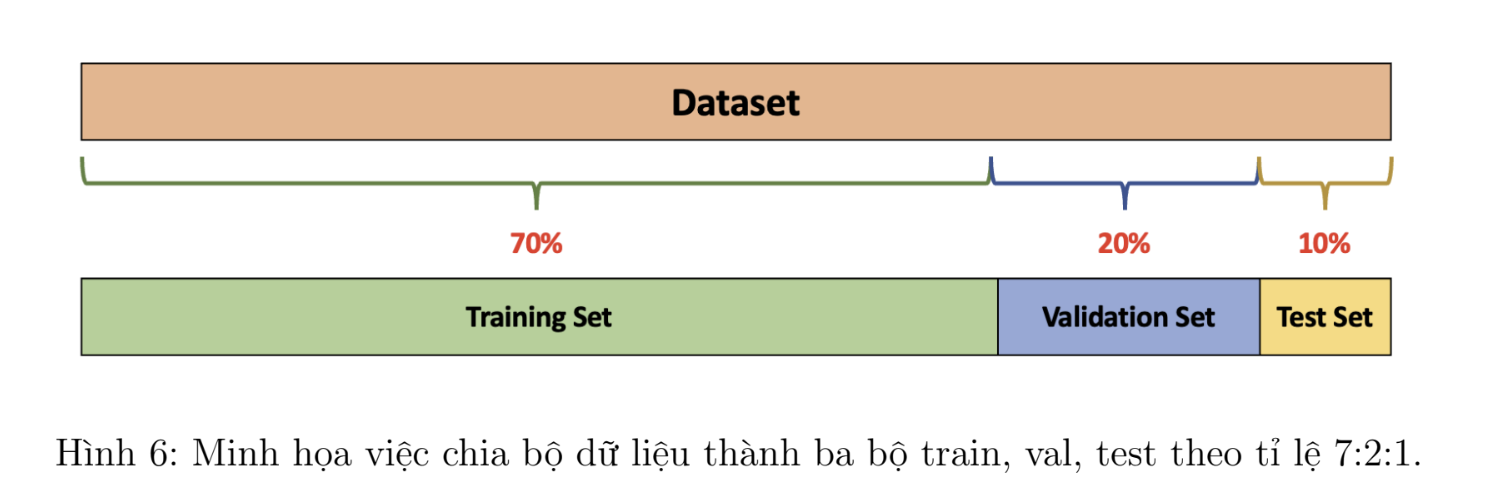

In [23]:
#Tạo dataloader
class CustomDataset ( Dataset ) :
 def __init__ (self , X, y) :
  self .X = X
  self .y = y

 def __len__ ( self ) :
  return len ( self .y)

 def __getitem__ ( self , idx ) :
  return self .X[ idx ] , self .y[ idx ]

In [24]:
#Sau khi khai báo class PyTorch Dataset, ta chỉ việc gói triển khai của các dataset này
#vào DataLoader là hoàn tất. Lưu ý rằng, ở đây ta sẽ khai báo luôn tham số batch
#size, vì DataLoader sẽ hỗ trợ chúng ta lấy batch một cách tối ưu hơn:
batch_size = 32
train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)
train_loader = DataLoader(train_dataset,
                          batch_size=batch_size,
                          shuffle=True)
val_loader = DataLoader(val_dataset,
                        batch_size=batch_size,
                        shuffle=False)

In [25]:
#Xây dựng mạng MLP
class MLP (nn. Module ) :
 def __init__ (self , input_dims , hidden_dims , output_dims ) :
  super () . __init__ ()
  self . linear1 = nn. Linear ( input_dims , hidden_dims )
  self . linear2 = nn. Linear ( hidden_dims , hidden_dims )
  self . output = nn. Linear ( hidden_dims , output_dims )

 def forward (self , x) :
  x = self . linear1 (x)
  x = F. relu (x)
  x = self . linear2 (x)
  x = F. relu (x)
  out = self . output (x)
  return out . squeeze (1)

In [26]:
#Tiếp theo, chúng ta thiết lập các tham số cho mạng MLP, bao gồm số lượng node cho
#đầu vào (input_dims), số node trong lớp ẩn (hidden_dims), và số node cho đầu ra (output_dims).
input_dims = X_train . shape [1]
output_dims = 1 # Should be 1 for regression
hidden_dims = 128

model = MLP ( input_dims = input_dims ,
hidden_dims = hidden_dims ,
output_dims = output_dims ) .to( device )

In [27]:
#Khai báo hàm loss và optimizer:
lr = 1e-2
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
#Xây dựng hàm tính điểm R2:
def r_squared(y_true, y_pred):
    # y_true = torch.Tensor(y_true).to(device) # No need to convert if already tensors
    # y_pred = torch.Tensor(y_pred).to(device) # No need to convert if already tensors
    mean_true = torch.mean(y_true)
    ss_tot = torch.sum((y_true - mean_true) ** 2)
    ss_res = torch.sum((y_true - y_pred) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    return r2
#R² = 1: Mô hình dự đoán hoàn hảo, không có sai số.
#R² = 0: Mô hình chỉ tốt bằng việc dự đoán giá trị trung bình của dữ liệu (không giải thích được variance nào).
#R² < 0: Mô hình tệ hơn so với việc chỉ dùng giá trị trung bình (thường xảy ra nếu mô hình overfit hoặc dữ liệu không tuyến tính).

In [28]:
#Huấn luyện mô hình
epochs = 100
train_losses = []
val_losses = []
train_r2 = []
val_r2 = []
for epoch in range(epochs):
    train_loss = 0.0
    train_target = []
    val_target = []
    train_predict = []
    val_predict = []
    model.train()
    for X_samples, y_samples in train_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device) # Remove unsqueeze(1)
        optimizer.zero_grad()
        outputs = model(X_samples)
        train_predict.extend(outputs.tolist())
        train_target.extend(y_samples.tolist()) # Remove unsqueeze(1)
        loss = criterion(outputs, y_samples)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    train_r2.append(r_squared(torch.tensor(train_target), torch.tensor(train_predict)).item())
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_samples, y_samples in val_loader:
            X_samples = X_samples.to(device)
            y_samples = y_samples.to(device) # Remove unsqueeze(1)
            outputs = model(X_samples)
            val_predict.extend(outputs.tolist())
            val_target.extend(y_samples.tolist()) # Remove unsqueeze(1)
            loss = criterion(outputs, y_samples)
            val_loss += loss.item()
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    val_r2.append(r_squared(torch.tensor(val_target), torch.tensor(val_predict)).item())
    print(f'\nEPOCH {epoch + 1}:\tTraining loss: {train_loss:.3f}\tValidation loss: {val_loss:.3f}')


EPOCH 1:	Training loss: 536.672	Validation loss: 400.145

EPOCH 2:	Training loss: 214.761	Validation loss: 50.062

EPOCH 3:	Training loss: 155.765	Validation loss: 104.924

EPOCH 4:	Training loss: 39.582	Validation loss: 21.683

EPOCH 5:	Training loss: 20.858	Validation loss: 9.249

EPOCH 6:	Training loss: 12.369	Validation loss: 46.050

EPOCH 7:	Training loss: 30.342	Validation loss: 20.687

EPOCH 8:	Training loss: 9.500	Validation loss: 8.395

EPOCH 9:	Training loss: 7.272	Validation loss: 5.687

EPOCH 10:	Training loss: 21.794	Validation loss: 11.440

EPOCH 11:	Training loss: 13.376	Validation loss: 18.287

EPOCH 12:	Training loss: 8.854	Validation loss: 9.780

EPOCH 13:	Training loss: 10.705	Validation loss: 12.370

EPOCH 14:	Training loss: 7.918	Validation loss: 8.748

EPOCH 15:	Training loss: 8.393	Validation loss: 16.641

EPOCH 16:	Training loss: 7.672	Validation loss: 18.166

EPOCH 17:	Training loss: 10.156	Validation loss: 8.914

EPOCH 18:	Training loss: 8.048	Validation loss

In [29]:
# Đánh giá mô hình trên tập test
model.eval()
y_true_test = []
y_pred_test = []
with torch.no_grad():
    X_test_tensor = X_test.to(device)
    y_test_tensor = y_test.to(device)
    outputs = model(X_test_tensor)
    y_pred_test.extend(outputs.tolist())
    y_true_test.extend(y_test_tensor.tolist())

test_r2 = r_squared(torch.tensor(y_true_test), torch.tensor(y_pred_test)).item()
print(f'\nTest R2 Score: {test_r2:.4f}')


Test R2 Score: 0.8753


Bài toán 2:

Phân loại với dữ liệu phi tuyến: Đây là một bài toán đơn giản về classification trên dữ liệu phi tuyến (nonlinear data), bài tập này nhằm mục đích mô tả về
khả năng của một mạng Multilayer Perceptron với những dữ liệu phân bố phức tạp hơn.

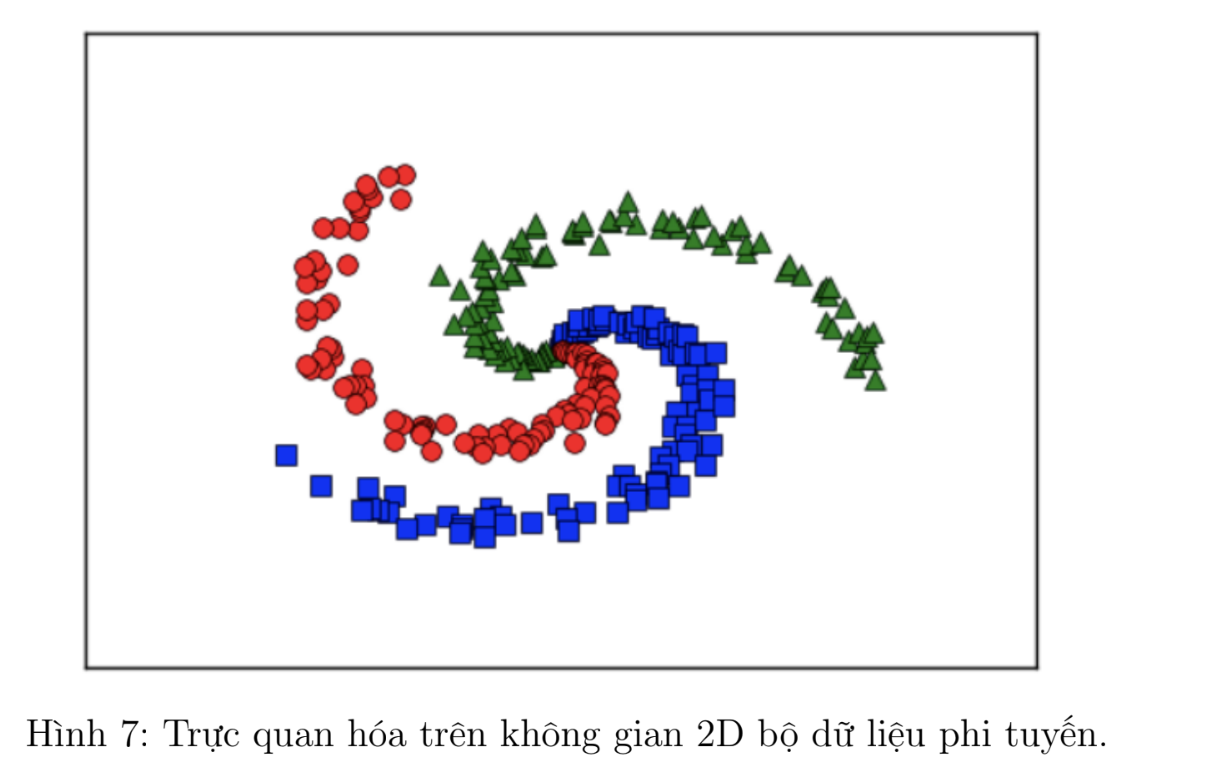

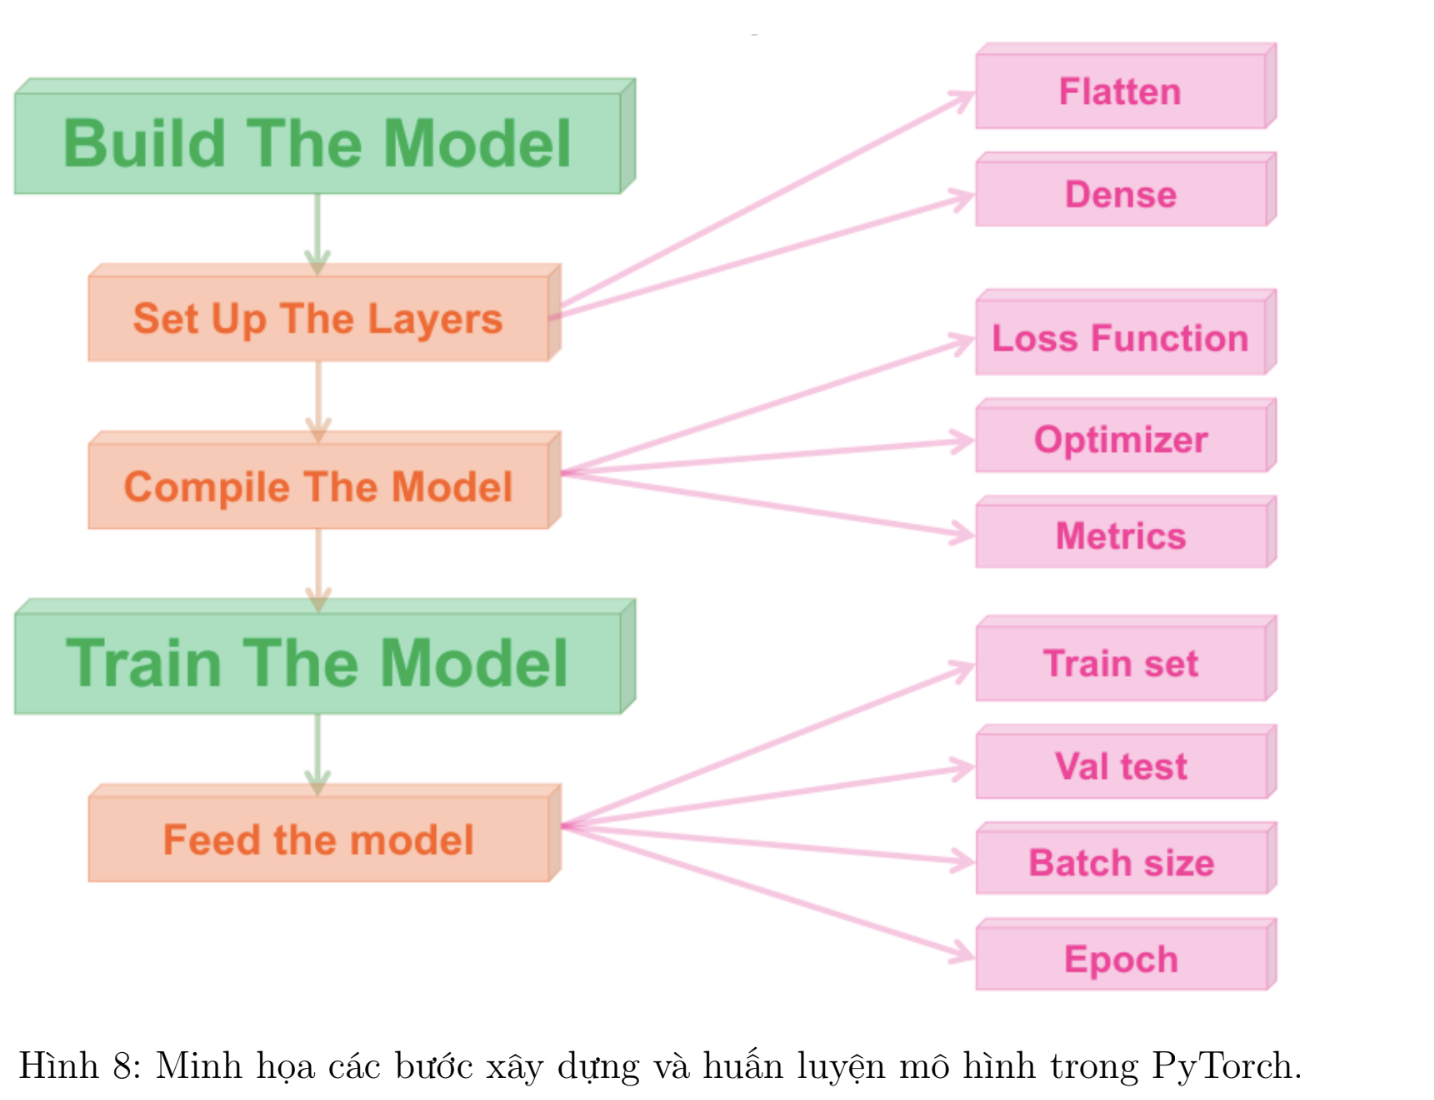

(300, 2) (300,)

EPOCH 1:	Training loss: 0.927	Validation loss: 0.824

EPOCH 2:	Training loss: 0.773	Validation loss: 0.784

EPOCH 3:	Training loss: 0.727	Validation loss: 0.787

EPOCH 4:	Training loss: 0.689	Validation loss: 0.745

EPOCH 5:	Training loss: 0.686	Validation loss: 0.749

EPOCH 6:	Training loss: 0.664	Validation loss: 0.720

EPOCH 7:	Training loss: 0.634	Validation loss: 0.761

EPOCH 8:	Training loss: 0.640	Validation loss: 0.675

EPOCH 9:	Training loss: 0.620	Validation loss: 0.653

EPOCH 10:	Training loss: 0.591	Validation loss: 0.629

EPOCH 11:	Training loss: 0.583	Validation loss: 0.634

EPOCH 12:	Training loss: 0.569	Validation loss: 0.615

EPOCH 13:	Training loss: 0.546	Validation loss: 0.592

EPOCH 14:	Training loss: 0.534	Validation loss: 0.570

EPOCH 15:	Training loss: 0.539	Validation loss: 0.557

EPOCH 16:	Training loss: 0.519	Validation loss: 0.552

EPOCH 17:	Training loss: 0.512	Validation loss: 0.521

EPOCH 18:	Training loss: 0.494	Validation loss: 0.514

EP

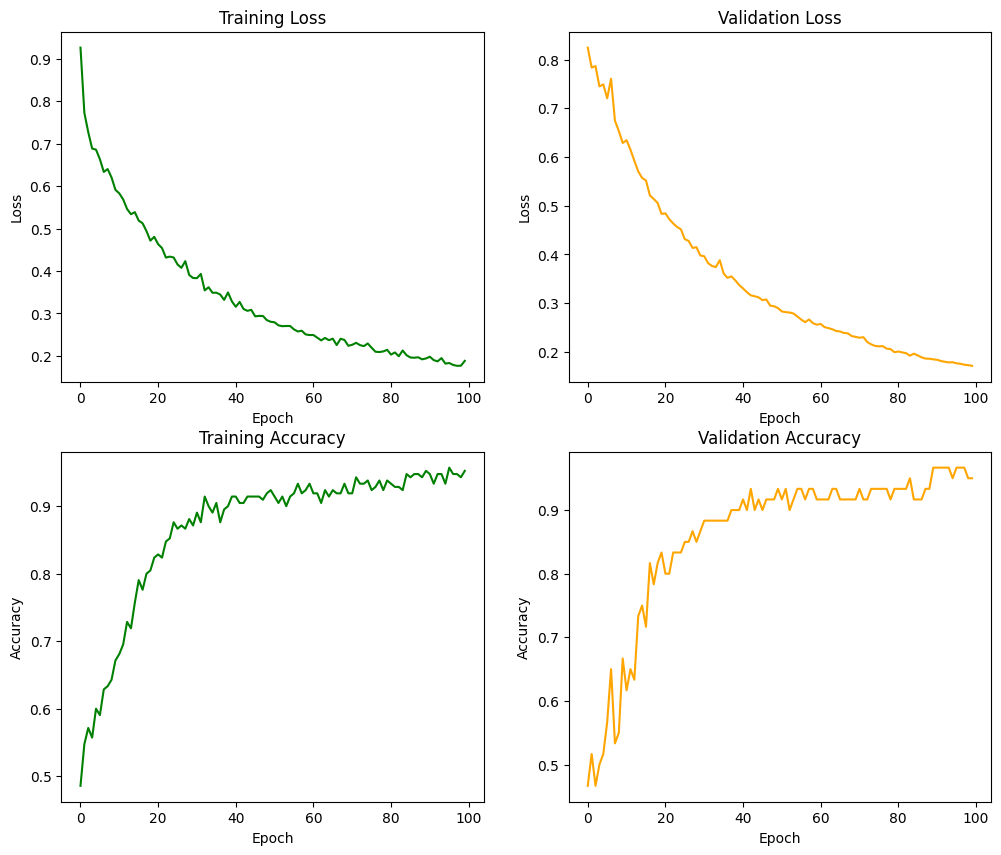

Evaluation on test set:
Accuracy: 0.9666666666666667


In [30]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# Định nghĩa random_state và device
random_state = 42  # Giá trị seed để tái lập kết quả
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Sử dụng GPU nếu có, иначе CPU

# Đọc bộ dữ liệu
# Dữ liệu được lưu dưới dạng .npy, tải bằng np.load để lấy dictionary với X (ma trận đặc trưng) và y (nhãn)
data_path = '/content/NonLinear_data.npy'
data = np.load(data_path, allow_pickle=True).item()
X, y = data['X'], data['labels']
print(X.shape, y.shape)  # In kích thước: (300, 2) (300,) => 300 mẫu 2 đặc trưng và 300 label tương ứng các mẫu

# Chia bộ dữ liệu train/val/test
# Chia theo tỉ lệ 7:2:1 (train:val:test)
val_size = 0.2
test_size = 0.125
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=val_size,
    random_state=random_state,
    shuffle=is_shuffle
)

X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train,
    test_size=test_size,
    random_state=random_state,
    shuffle=is_shuffle
)

# Chuẩn hóa đặc trưng đầu vào
# Sử dụng StandardScaler để chuẩn hóa dữ liệu (mean=0, std=1)
normalizer = StandardScaler()
X_train = normalizer.fit_transform(X_train)
X_val = normalizer.transform(X_val)
X_test = normalizer.transform(X_test)

# Chuyển dữ liệu sang tensor PyTorch
X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_val = torch.tensor(y_val, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

# Xây dựng DataLoader
# Định nghĩa class CustomDataset để quản lý dữ liệu
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Thiết lập batch size và tạo DataLoader cho train, val, test
batch_size = 32
train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)
test_dataset = CustomDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Xây dựng mạng MLP
# MLP với 1 lớp ẩn, sử dụng ReLU để xử lý phi tuyến
class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLP, self).__init__()
        self.linear1 = nn.Linear(input_dims, hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        out = self.output(x)
        return out.squeeze(1)

# Thiết lập tham số cho mô hình
input_dims = X_train.shape[1]  # Số đặc trưng đầu vào (2)
output_dims = torch.unique(y_train).shape[0]  # Số lớp (3)
hidden_dims = 128  # Số node lớp ẩn lớn hơn để xử lý phi tuyến

model = MLP(input_dims=input_dims, hidden_dims=hidden_dims, output_dims=output_dims).to(device)

# Khai báo hàm loss và optimizer
# Sử dụng CrossEntropyLoss cho phân loại đa lớp, optimizer SGD
lr = 1e-1
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

# Xây dựng hàm tính độ chính xác
# Tính accuracy: số dự đoán đúng / tổng số mẫu
def compute_accuracy(y_hat, y_true):
    _, y_hat = torch.max(y_hat, dim=1)
    correct = (y_hat == y_true).sum().item()
    accuracy = correct / len(y_true)
    return accuracy

# Huấn luyện mô hình
# Huấn luyện qua 100 epochs, theo dõi loss và accuracy
epochs = 100
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(epochs):
    train_loss = 0.0
    train_target = []
    train_predict = []
    model.train()
    for X_samples, y_samples in train_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)
        optimizer.zero_grad()
        outputs = model(X_samples)
        loss = criterion(outputs, y_samples)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        train_predict.append(outputs.detach().cpu())
        train_target.append(y_samples.cpu())

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    train_predict = torch.cat(train_predict)
    train_target = torch.cat(train_target)
    train_acc = compute_accuracy(train_predict, train_target)
    train_accs.append(train_acc)

    val_loss = 0.0
    val_target = []
    val_predict = []
    model.eval()
    with torch.no_grad():
        for X_samples, y_samples in val_loader:
            X_samples = X_samples.to(device)
            y_samples = y_samples.to(device)
            outputs = model(X_samples)
            val_loss += criterion(outputs, y_samples).item()

            val_predict.append(outputs.cpu())
            val_target.append(y_samples.cpu())

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    val_predict = torch.cat(val_predict)
    val_target = torch.cat(val_target)
    val_acc = compute_accuracy(val_predict, val_target)
    val_accs.append(val_acc)

    print(f'\nEPOCH {epoch + 1}:\tTraining loss: {train_loss:.3f}\tValidation loss: {val_loss:.3f}')

# Trực quan hóa kết quả huấn luyện
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(train_losses, color='green')
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

ax[0, 1].plot(val_losses, color='orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

ax[1, 0].plot(train_accs, color='green')
ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')

ax[1, 1].plot(val_accs, color='orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

plt.show()

# Đánh giá mô hình
# Đánh giá trên tập test sử dụng test_loader
test_target = []
test_predict = []
model.eval()

with torch.no_grad():
    for X_samples, y_samples in test_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)
        outputs = model(X_samples)

        test_predict.append(outputs.cpu())
        test_target.append(y_samples.cpu())

test_predict = torch.cat(test_predict)
test_target = torch.cat(test_target)
test_acc = compute_accuracy(test_predict, test_target)

print('Evaluation on test set:')
print(f'Accuracy: {test_acc}')

Bài toán 3: Phân loại cảm xúc trên ảnh.

In [32]:
! gdown --id 1GaTMURqIQTjtalbNVAyVgPIEis21A0r8cái


/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1GaTMURqIQTjtalbNVAyVgPIEis21A0r8
From (redirected): https://drive.google.com/uc?id=1GaTMURqIQTjtalbNVAyVgPIEis21A0r8&confirm=t&uuid=81d11ba0-ecda-4b69-9c7c-35567a1af09d
To: /content/FER-2013.zip
100% 63.3M/63.3M [00:00<00:00, 102MB/s]


In [38]:
!rm -rf /content/train /content/test  # Xóa thư mục train và test nếu tồn tại
!unzip /content/FER-2013.zip

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
  inflating: train/sad/Training_65242339.jpg  
  inflating: train/sad/Training_65267116.jpg  
  inflating: train/sad/Training_65275626.jpg  
  inflating: train/sad/Training_6529266.jpg  
  inflating: train/sad/Training_65329617.jpg  
  inflating: train/sad/Training_65338712.jpg  
  inflating: train/sad/Training_65338797.jpg  
  inflating: train/sad/Training_65387162.jpg  
  inflating: train/sad/Training_65404494.jpg  
  inflating: train/sad/Training_65426218.jpg  
  inflating: train/sad/Training_65430136.jpg  
  inflating: train/sad/Training_65437377.jpg  
  inflating: train/sad/Training_6545735.jpg  
  inflating: train/sad/Training_65463385.jpg  
  inflating: train/sad/Training_65473985.jpg  
  inflating: train/sad/Training_65502829.jpg  
  inflating: train/sad/Training_65505359.jpg  
  inflating: train/sad/Training_65508578.jpg  
  inflating: train/sad/Training_65516023.jpg  
  inflating: train/sad/Training_65524027.jpg  
  inf

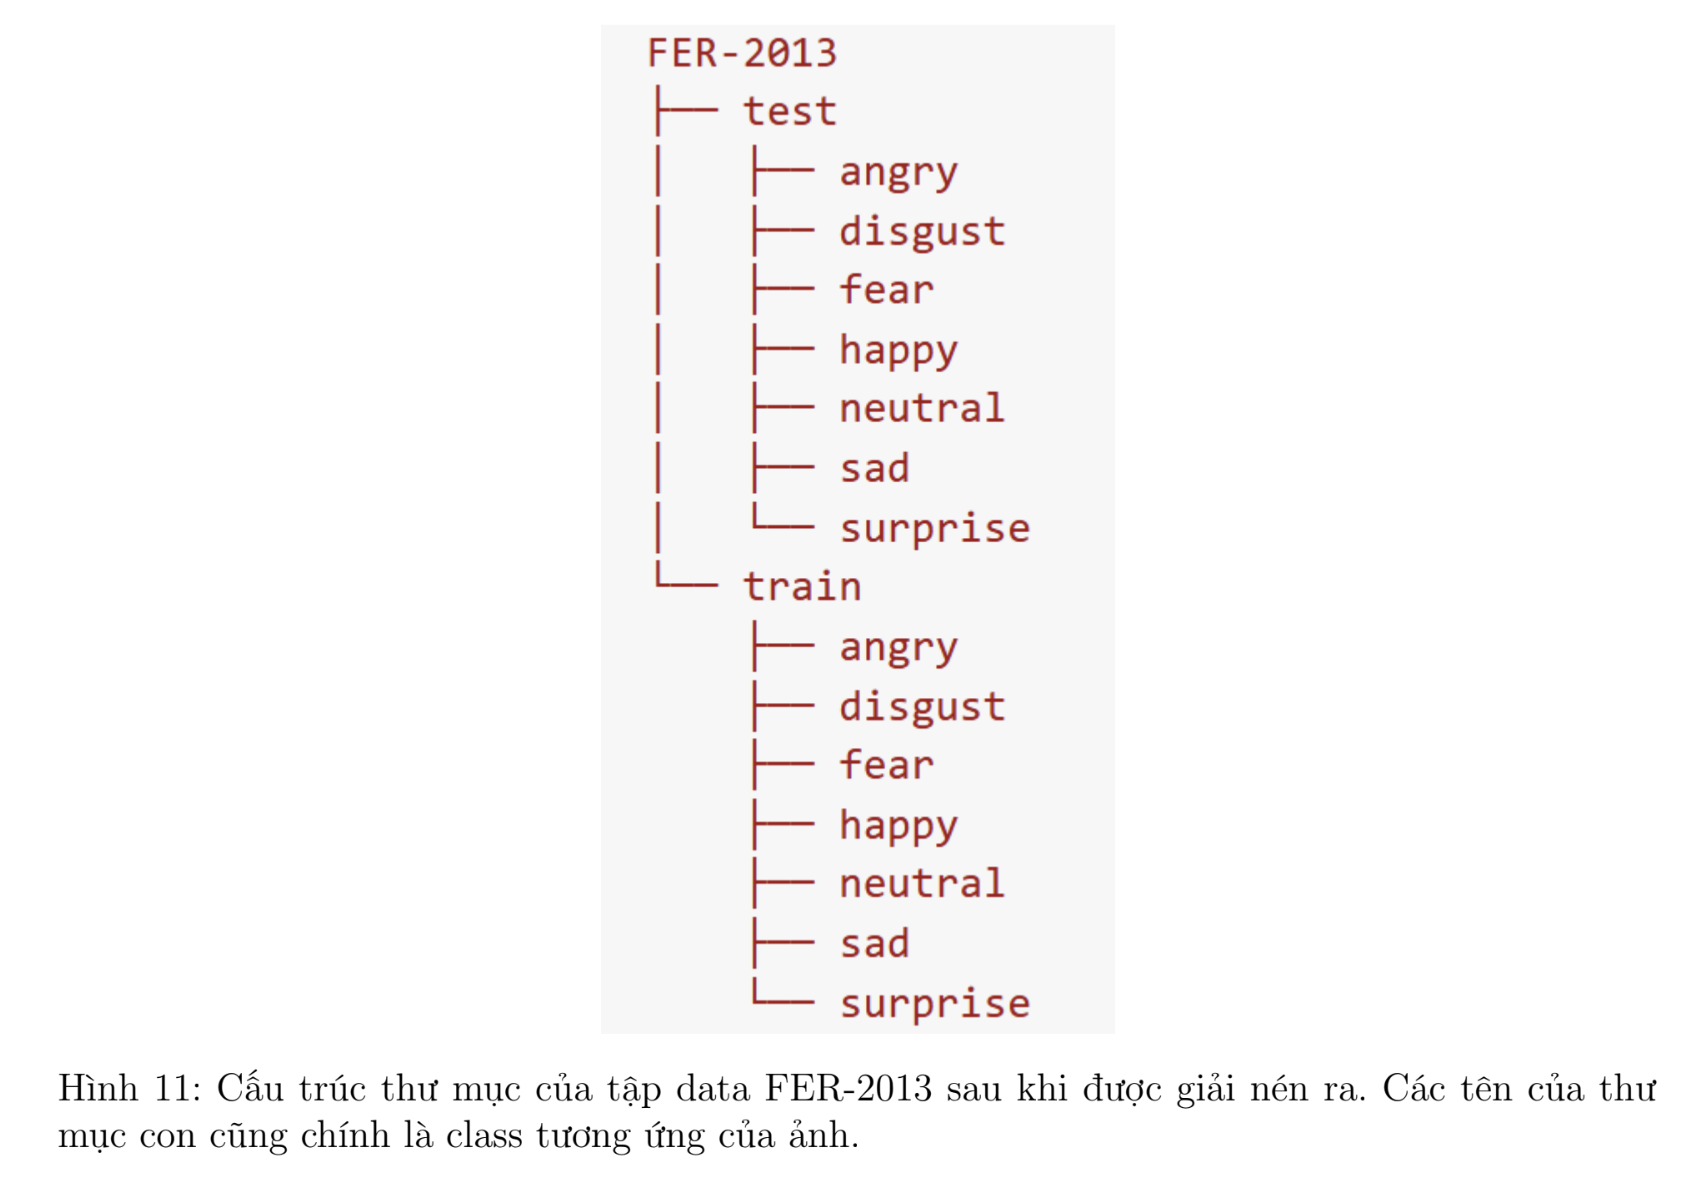

Image height: 128
Image width: 128

EPOCH 1:	Training loss: 1.927	Validation loss: 1.880

EPOCH 2:	Training loss: 1.849	Validation loss: 1.814

EPOCH 3:	Training loss: 1.806	Validation loss: 1.784

EPOCH 4:	Training loss: 1.784	Validation loss: 1.766

EPOCH 5:	Training loss: 1.766	Validation loss: 1.750

EPOCH 6:	Training loss: 1.748	Validation loss: 1.731

EPOCH 7:	Training loss: 1.726	Validation loss: 1.711

EPOCH 8:	Training loss: 1.704	Validation loss: 1.693

EPOCH 9:	Training loss: 1.684	Validation loss: 1.679

EPOCH 10:	Training loss: 1.667	Validation loss: 1.663

EPOCH 11:	Training loss: 1.654	Validation loss: 1.655

EPOCH 12:	Training loss: 1.642	Validation loss: 1.647

EPOCH 13:	Training loss: 1.631	Validation loss: 1.639

EPOCH 14:	Training loss: 1.621	Validation loss: 1.632

EPOCH 15:	Training loss: 1.611	Validation loss: 1.626

EPOCH 16:	Training loss: 1.602	Validation loss: 1.624

EPOCH 17:	Training loss: 1.593	Validation loss: 1.616

EPOCH 18:	Training loss: 1.584	Validat

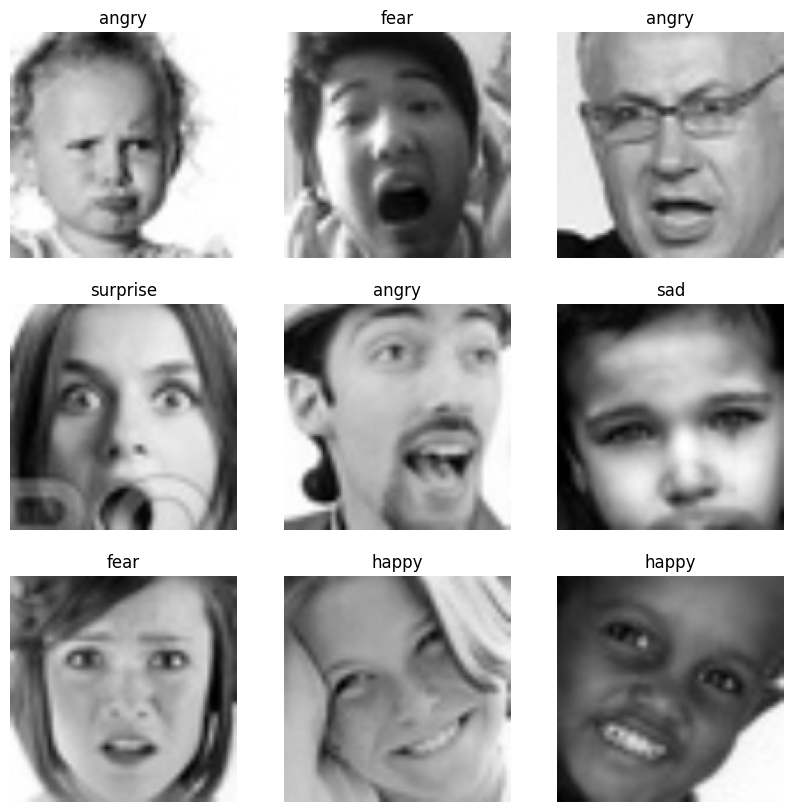

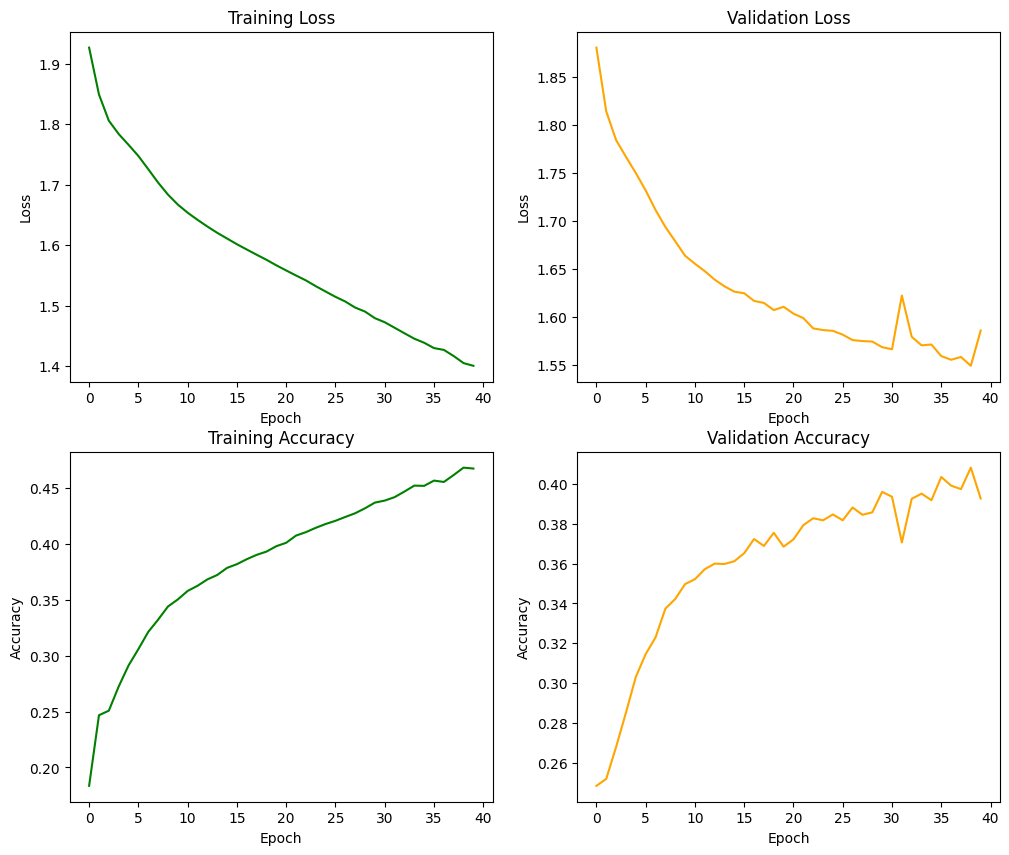

Evaluation on test set:
Accuracy: 0.3978824185009752


In [39]:
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Resize
from torchvision.io import read_image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler



# Đọc số lượng class trong dataset
# Thiết lập đường dẫn đến thư mục train và test, lấy danh sách class từ thư mục train
train_dir = '/content/train'
test_dir = '/content/test'

classes = os.listdir(train_dir)

label2idx = {cls: idx for idx, cls in enumerate(classes)}
idx2label = {idx: cls for cls, idx in label2idx.items()}

# Xây dựng DataLoader
# Lấy kích thước ảnh (resize về 128x128)
test_img_path = '/content/train/angry/Training_10118481.jpg'
img = cv2.imread(test_img_path)
img_height, img_width = (128, 128)
print(f'Image height: {img_height}')
print(f'Image width: {img_width}')

# Định nghĩa class ImageDataset để quản lý dữ liệu ảnh, hỗ trợ split train/val
class ImageDataset(Dataset):
    def __init__(self, img_dir, norm, label2idx, split='train', train_ratio=0.8):
        self.resize = Resize((img_height, img_width))
        self.norm = norm
        self.split = split
        self.train_ratio = train_ratio
        self.img_dir = img_dir
        self.label2idx = label2idx
        self.img_paths, self.img_labels = self.read_img_files()

        if split in ['train', 'val'] and 'train' in img_dir.lower():
            train_data, val_data = train_test_split(
                list(zip(self.img_paths, self.img_labels)),
                train_size=train_ratio,
                random_state=random_state,
                stratify=self.img_labels
            )

            if split == 'train':
                self.img_paths, self.img_labels = zip(*train_data)
            elif split == 'val':
                self.img_paths, self.img_labels = zip(*val_data)

    def read_img_files(self):
        img_paths = []
        img_labels = []
        for cls in self.label2idx.keys():
            for img in os.listdir(os.path.join(self.img_dir, cls)):
                img_paths.append(os.path.join(self.img_dir, cls, img))
                img_labels.append(cls)

        return img_paths, img_labels

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        cls = self.img_labels[idx]
        img = self.resize(read_image(img_path))
        img = img.type(torch.float32)
        label = self.label2idx[cls]
        if self.norm:
            img = (img / 127.5) - 1
        return img, label

# Khởi tạo DataLoader cho train, val, test với batch size 256
batch_size = 256

train_dataset = ImageDataset(train_dir, True, label2idx, split='train')
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = ImageDataset(train_dir, True, label2idx, split='val')
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

test_dataset = ImageDataset(test_dir, True, label2idx, split='test')
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Trực quan hóa dữ liệu
# Lấy một batch từ train_loader và hiển thị 9 ảnh đầu tiên với nhãn
image_batch, label_batch = next(iter(train_loader))

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    minv = image_batch[i].numpy().min()
    maxv = image_batch[i].numpy().max()
    plt.imshow(np.squeeze(image_batch[i].numpy()), vmin=minv, vmax=maxv, cmap="gray")
    label = label_batch[i]
    plt.title(idx2label[label.item()])
    plt.axis("off")

# Xây dựng mạng MLP
# MLP với nhiều lớp ẩn để xử lý ảnh (input flatten)
class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLP, self).__init__()
        self.linear1 = nn.Linear(input_dims, hidden_dims * 4)
        self.linear2 = nn.Linear(hidden_dims * 4, hidden_dims * 2)
        self.linear3 = nn.Linear(hidden_dims * 2, hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims)

    def forward(self, x):
        x = nn.Flatten()(x)
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.relu(x)
        x = self.linear3(x)
        x = F.relu(x)
        out = self.output(x)
        return out.squeeze(1)

# Thiết lập tham số cho mô hình
input_dims = img_height * img_width
output_dims = len(classes)
hidden_dims = 64
lr = 1e-2

model = MLP(input_dims=input_dims, hidden_dims=hidden_dims, output_dims=output_dims).to(device)

# Khai báo hàm loss và optimizer
# Sử dụng CrossEntropyLoss cho phân loại đa lớp, optimizer SGD
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

# Xây dựng hàm tính độ chính xác
# Tính accuracy: số dự đoán đúng / tổng số mẫu
def compute_accuracy(y_hat, y_true):
    _, y_hat = torch.max(y_hat, dim=1)
    correct = (y_hat == y_true).sum().item()
    accuracy = correct / len(y_true)
    return accuracy

# Huấn luyện mô hình
# Huấn luyện qua 40 epochs, theo dõi loss và accuracy
epochs = 40
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(epochs):
    train_loss = 0.0
    train_target = []
    train_predict = []
    model.train()
    for X_samples, y_samples in train_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)
        optimizer.zero_grad()
        outputs = model(X_samples)
        loss = criterion(outputs, y_samples)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        train_predict.append(outputs.detach().cpu())
        train_target.append(y_samples.cpu())

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    train_predict = torch.cat(train_predict)
    train_target = torch.cat(train_target)
    train_acc = compute_accuracy(train_predict, train_target)
    train_accs.append(train_acc)

    val_loss = 0.0
    val_target = []
    val_predict = []
    model.eval()
    with torch.no_grad():
        for X_samples, y_samples in val_loader:
            X_samples = X_samples.to(device)
            y_samples = y_samples.to(device)
            outputs = model(X_samples)
            val_loss += criterion(outputs, y_samples).item()

            val_predict.append(outputs.cpu())
            val_target.append(y_samples.cpu())

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    val_predict = torch.cat(val_predict)
    val_target = torch.cat(val_target)
    val_acc = compute_accuracy(val_predict, val_target)
    val_accs.append(val_acc)

    print(f'\nEPOCH {epoch + 1}:\tTraining loss: {train_loss:.3f}\tValidation loss: {val_loss:.3f}')

# Trực quan hóa kết quả huấn luyện
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(train_losses, color='green')
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

ax[0, 1].plot(val_losses, color='orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

ax[1, 0].plot(train_accs, color='green')
ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')

ax[1, 1].plot(val_accs, color='orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

plt.show()

# Đánh giá mô hình
# Đánh giá trên tập test sử dụng test_loader
test_target = []
test_predict = []
model.eval()
with torch.no_grad():
    for X_samples, y_samples in test_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)
        outputs = model(X_samples)

        test_predict.append(outputs.cpu())
        test_target.append(y_samples.cpu())

test_predict = torch.cat(test_predict)
test_target = torch.cat(test_target)
test_acc = compute_accuracy(test_predict, test_target)

print('Evaluation on test set:')
print(f'Accuracy: {test_acc}')